In [47]:
########################################
## import packages
########################################
import os
import re
import csv
import codecs
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
# from string import punctuation

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from TextToWord import text_to_wordlist

# import sys
# reload(sys)
# sys.setdefaultencoding('utf-8')

########################################
## set directories and parameters
########################################
BASE_DIR = '../quora/data/'
EMBEDDING_FILE = BASE_DIR + 'GoogleNews-vectors-negative300.bin'
TRAIN_DATA_FILE = BASE_DIR + 'train_aux.csv'
TEST_DATA_FILE = BASE_DIR + 'test_aux.csv'
MAX_SEQUENCE_LENGTH = 30
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1

num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

act = 'relu'
re_weight = True # whether to re-weight classes to fit the 17.5% share in test set

STAMP = 'lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, rate_drop_dense)


In [9]:
########################################
## index word vectors
########################################
print('Indexing word vectors')

word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

Indexing word vectors
Found 3000000 word vectors of word2vec


In [14]:
########################################
## process train texts in datasets
########################################
print('Processing train dataset')
texts_1 = [] 
texts_2 = []
labels = []
with codecs.open(TRAIN_DATA_FILE, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        texts_1.append(text_to_wordlist(values[3]))
        texts_2.append(text_to_wordlist(values[4]))
        labels.append(int(values[5]))
print('Found %s texts in train.csv' % len(texts_1))

Processing train dataset
Found 37 texts in train.csv


In [17]:
########################################
## process train texts in datasets
########################################
print('Processing test dataset')
test_texts_1 = []
test_texts_2 = []
test_ids = []
with codecs.open(TEST_DATA_FILE, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        if len(values) < 4:
            test_texts_1.append(text_to_wordlist(values[1]))
            test_texts_2.append(text_to_wordlist(values[2]))
            test_ids.append(values[0])
print('Found %s texts in test.csv' % len(test_texts_1))

Processing test dataset
Found 21 texts in test.csv


In [18]:
########################################
## tokenizing words
########################################

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_1 + texts_2 + test_texts_1 + test_texts_2)

sequences_1 = tokenizer.texts_to_sequences(texts_1)
sequences_2 = tokenizer.texts_to_sequences(texts_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(labels)
print('Shape of data tensor:', data_1.shape)
print('Shape of label tensor:', labels.shape)

test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
test_ids = np.array(test_ids)

Found 501 unique tokens
Shape of data tensor: (37, 30)
Shape of label tensor: (37,)


In [19]:
########################################
## prepare embeddings
########################################
print('Preparing embedding matrix')

nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix
Null word embeddings: 37


In [25]:
########################################
## sample train/validation data
########################################
#np.random.seed(1234)
perm = np.random.permutation(len(data_1))
idx_train = perm[:int(len(data_1)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(data_1)*(1-VALIDATION_SPLIT)):]

data_1_train = np.vstack((data_1[idx_train], data_2[idx_train]))
data_2_train = np.vstack((data_2[idx_train], data_1[idx_train]))
labels_train = np.concatenate((labels[idx_train], labels[idx_train]))

data_1_val = np.vstack((data_1[idx_val], data_2[idx_val]))
data_2_val = np.vstack((data_2[idx_val], data_1[idx_val]))
labels_val = np.concatenate((labels[idx_val], labels[idx_val]))

weight_val = np.ones(len(labels_val))
if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344

In [41]:
########################################
## define the model structure
########################################
embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)
lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

merged = concatenate([x1, y1])
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

preds = Dense(1, activation='sigmoid')(merged)

########################################
## add class weight
########################################
if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None

########################################
## train the model
########################################
model = Model(inputs=[sequence_1_input, sequence_2_input], \
        outputs=preds)
model.compile(loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['acc'])
model.summary()
print(STAMP)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 300)      150600      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 270)          616680      embedding_1[0][0]                
          

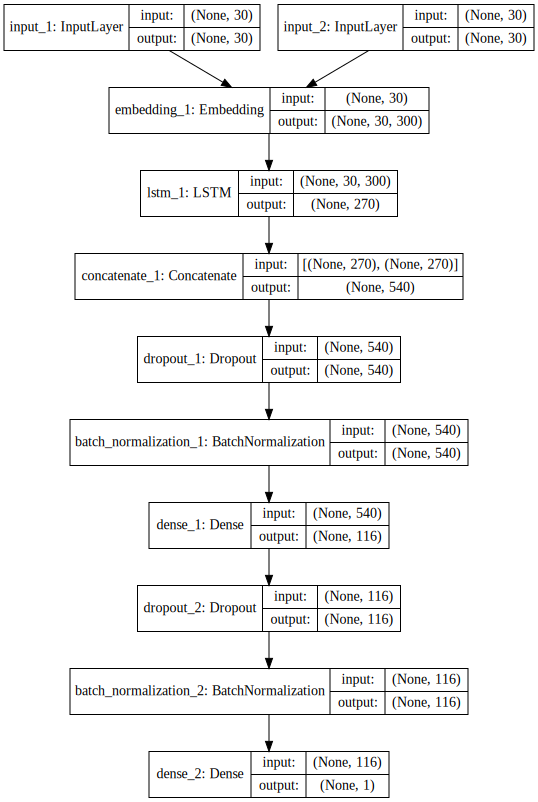

In [43]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))


In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

tensorboard_callback = TensorBoard('./logs/')

hist = model.fit([data_1_train, data_2_train], labels_train, \
        validation_data=([data_1_val, data_2_val], labels_val, weight_val), \
        epochs=200, batch_size=2048, shuffle=True, \
        class_weight=class_weight, callbacks=[early_stopping, model_checkpoint, tensorboard_callback])

Train on 66 samples, validate on 8 samples
Epoch 1/200
66/66 [==============================] - 0s 5ms/step - loss: 0.0522 - acc: 1.0000 - val_loss: 1.3935 - val_acc: 0.2500
Epoch 2/200
66/66 [==============================] - 0s 5ms/step - loss: 0.0586 - acc: 1.0000 - val_loss: 1.2276 - val_acc: 0.2500
Epoch 3/200
66/66 [==============================] - 0s 5ms/step - loss: 0.0356 - acc: 1.0000 - val_loss: 1.2572 - val_acc: 0.2500
Epoch 4/200
66/66 [==============================] - 0s 5ms/step - loss: 0.0281 - acc: 1.0000 - val_loss: 1.2799 - val_acc: 0.2500
Epoch 5/200
66/66 [==============================] - 0s 5ms/step - loss: 0.0266 - acc: 1.0000 - val_loss: 1.3779 - val_acc: 0.2500
Epoch 6/200
66/66 [==============================] - 0s 5ms/step - loss: 0.0246 - acc: 1.0000 - val_loss: 1.3678 - val_acc: 0.2500
Epoch 7/200
66/66 [==============================] - 0s 6ms/step - loss: 0.0217 - acc: 1.0000 - val_loss: 1.3553 - val_acc: 0.2500
Epoch 8/200
66/66 [=====================

In [45]:
model.load_weights(bst_model_path)
bst_val_score = min(hist.history['val_loss'])

In [46]:
bst_val_score

0.8130847215652466